In [2]:
import os
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt


In [3]:
import os

data_dir = './chapman_data/WFDBRecords/'  # Set this correctly
records = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.hea'):
            full_path = os.path.join(root, file)
            try:
                with open(full_path, 'r') as f:
                    lines = f.readlines()
                    dx_line = [line for line in lines if line.startswith('#Dx')]
                    if dx_line:
                        label = dx_line[0].strip().split(':')[1].strip()
                        record_id = file.replace('.hea', '')
                        records.append(record_id)
                        labels.append(label)
            except Exception as e:
                print(f"Error reading {file}: {e}")

# Show sample output
for r, l in zip(records[:5], labels[:5]):
    print(f"{r}: {l}")


JS02937: 164889003,55827005,164934002
JS03022: 426783006
JS03023: 164890007,39732003,164934002
JS02936: 426783006
JS02934: 426177001,164934002


In [4]:
import os
import pandas as pd

# ==== Load SNOMED Mapping File ====
mapping_path = './chapman_data/ConditionNames_SNOMED-CT.csv'  # or .xlsx if applicable
map_df = pd.read_csv(mapping_path)
code_to_label = dict(zip(map_df['Snomed_CT'].astype(str), map_df['Acronym Name']))

# ==== Paths ====
data_dir = './chapman_data/WFDBRecords/'  # Adjust this to your folder
record_ids = []
label_lists = []

# ==== Walk Through .hea Files ====
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.hea'):
            path = os.path.join(root, file)
            try:
                with open(path, 'r') as f:
                    lines = f.readlines()
                    dx_line = [line for line in lines if line.startswith('#Dx')]
                    if dx_line:
                        snomed_codes = dx_line[0].strip().split(':')[1].strip()
                        snomed_list = snomed_codes.split(',')
                        labels = [code_to_label.get(code.strip(), f"UNK_{code.strip()}") for code in snomed_list]
                        record_id = file.replace('.hea', '')
                        record_ids.append(record_id)
                        label_lists.append(','.join(labels))  # Join as CSV-style string
            except Exception as e:
                print(f"Error reading {file}: {e}")

# ==== Create and Save DataFrame ====
df = pd.DataFrame({
    'RecordID': record_ids,
    'Labels': label_lists
})

df.to_csv('REFERENCE.csv', index=False)
print(f"✅ Saved REFERENCE.csv with {len(df)} records.")


✅ Saved REFERENCE.csv with 45153 records.


In [5]:
import os
import wfdb
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# Load REFERENCE.csv
df = pd.read_csv('REFERENCE.csv')
record_ids = set(df['RecordID'].tolist())
record_to_labels = dict(zip(df['RecordID'], df['Labels']))

# Store data
X = []
Y = []

# Walk all nested folders inside WFDBRecords
data_dir = './chapman_data/WFDBRecords/'

for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.hea'):
            record_id = file.replace('.hea', '')
            if record_id not in record_ids:
                continue  # Skip unknown records

            full_path = os.path.join(root, record_id)

            try:
                record = wfdb.rdrecord(full_path)
                lead_index = record.sig_name.index('I')  # Extract Lead I
                signal = record.p_signal[:, lead_index]  # shape: (5000,)

                X.append(signal)
                label_str = record_to_labels[record_id]
                Y.append(label_str.split(','))  # For multi-label binarization

            except Exception as e:
                print(f"⚠️ Error loading {record_id}: {e}")

# Convert to arrays
X = np.stack(X)  # shape: (N, 5000)
mlb = MultiLabelBinarizer()
Y_bin = mlb.fit_transform(Y)

print(f"✅ Loaded {len(X)} ECG signals with shape {X.shape}")
print(f"🩺 Classes: {mlb.classes_}")


⚠️ Error loading JS00001-checkpoint: [Errno 2] No such file or directory: '/Users/anurag/Desktop/venv/chapman_data/WFDBRecords/01/010/.ipynb_checkpoints/JS00001.mat'
⚠️ Error loading JS01052: time data '/' does not match format '%d/%m/%Y'
⚠️ Error loading JS23074: list index out of range
✅ Loaded 45150 ECG signals with shape (45150, 5000)
🩺 Classes: ['1AVB' '2AVB' '2AVB1' '3AVB' 'ABI' 'AF' 'AFIB' 'ALS' 'APB' 'AQW' 'ARS'
 'AT' 'AVB' 'AVRT' 'CCR' 'CR' 'ERV' 'FQRS' 'IVB' 'JEB' 'JPT' 'LFBBB' 'LVH'
 'LVQRSAL' 'MISW' 'PRIE' 'PWC' 'QTIE' 'RAH' 'RBBB' 'RVH' 'SA' 'SAAWR' 'SB'
 'SR' 'ST' 'STDD' 'STE' 'STTC' 'STTU' 'SVT' 'TWC' 'TWO' 'UNK_10370003'
 'UNK_106068003' 'UNK_111288001' 'UNK_164896001' 'UNK_17366009'
 'UNK_233892002' 'UNK_251120003' 'UNK_251166008' 'UNK_251170000'
 'UNK_251187003' 'UNK_251205003' 'UNK_251223006' 'UNK_29320008'
 'UNK_365413008' 'UNK_418818005' 'UNK_425856008' 'UNK_426183003'
 'UNK_426627000' 'UNK_426648003' 'UNK_426664006' 'UNK_427172004'
 'UNK_445118002' 'UNK_445211001'

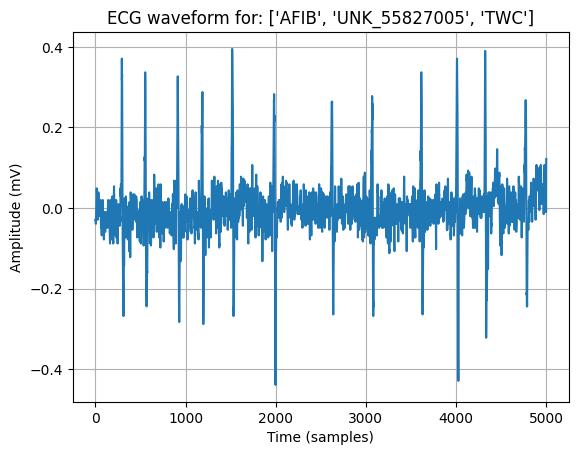

In [6]:
import matplotlib.pyplot as plt

plt.plot(X[0])
plt.title(f"ECG waveform for: {Y[0]}")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude (mV)")
plt.grid(True)
plt.show()

In [7]:
leadI_labels = ['SR', 'SB', 'ST', 'AF', 'AFIB', 'SA', 'SAAWR', 'SVT', 'APB', 'AT', 'VPB', 'JPT']

filtered_X = []
filtered_Y = []

for i in range(len(X)):
    labels = [label for label in Y[i] if label in leadI_labels]
    if labels:  # Keep only if some valid labels remain
        filtered_X.append(X[i])
        filtered_Y.append(labels)

filtered_X = np.stack(filtered_X)
mlb = MultiLabelBinarizer()
filtered_Y_bin = mlb.fit_transform(filtered_Y)

import numpy as np
counts = np.sum(filtered_Y_bin, axis=0)
for label, count in zip(mlb.classes_, counts):
    print(f"{label}: {count}")


AF: 8060
AFIB: 1780
APB: 1312
AT: 297
JPT: 11
SA: 2550
SAAWR: 2
SB: 16559
SR: 8125
ST: 7254
SVT: 724
VPB: 294


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    filtered_X, filtered_Y_bin, test_size=0.2, random_state=42)

# Keras needs 3D input (N, 5000, 1)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(X_train.shape, y_train.shape)


(35384, 5000, 1) (35384, 12)


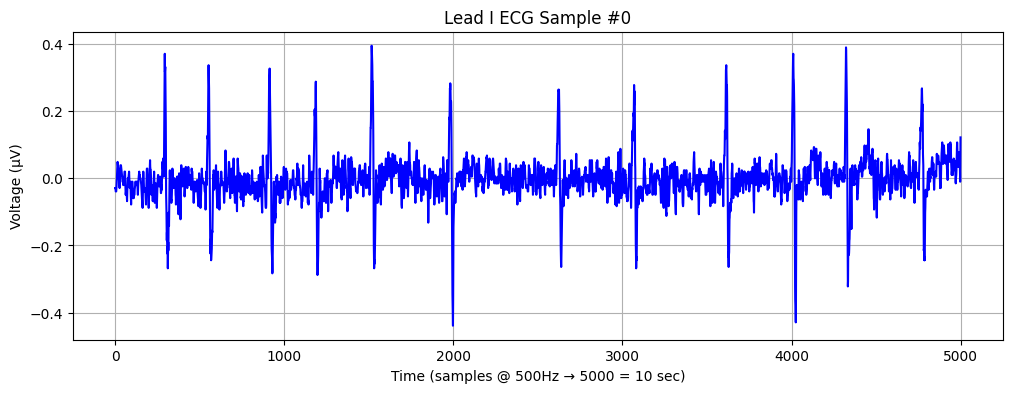

Labels: ['AFIB']


[('AFIB',)]

In [9]:
import matplotlib.pyplot as plt

# Pick a sample index (e.g., 0)
i = 0

# Plot the ECG waveform
plt.figure(figsize=(12, 4))
plt.plot(filtered_X[i], color='blue')
plt.title(f"Lead I ECG Sample #{i}")
plt.xlabel("Time (samples @ 500Hz → 5000 = 10 sec)")
plt.ylabel("Voltage (μV)")
plt.grid(True)
plt.show()

print("Labels:", filtered_Y[i])  # raw list
mlb.inverse_transform(np.array([filtered_Y_bin[i]]))

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np

# Convert your NumPy arrays to float32 (important for PyTorch)
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)

# Custom PyTorch Dataset
class ECGDataset(Dataset):
    def __init__(self, signals, labels):
        self.signals = signals
        self.labels = labels

    def __len__(self):
        return len(self.signals)

    def __getitem__(self, idx):
        signal = self.signals[idx]        # shape: (5000, 1)
        label = self.labels[idx]          # multi-label vector
        return torch.tensor(signal), torch.tensor(label)

train_dataset = ECGDataset(X_train, y_train)
val_dataset = ECGDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


In [11]:
class ECG1DCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECG1DCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(2)

        self.conv3 = nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(2)

        self.flattened_size = 64 * (5000 // 8)  # After 3 poolings (factor of 8)

        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)
        self.sigmoid = nn.Sigmoid()  # multi-label output

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 1, 5000)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool3(torch.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, self.flattened_size)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.sigmoid(self.fc2(x))  # multi-label output
        return x


In [12]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model = ECG1DCNN(num_classes=y_train.shape[1]).to(device)
criterion = nn.BCELoss()  # because output is multi-label (sigmoid)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [13]:
for epoch in range(5):  # Increase this for better results
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1, Loss: 0.2486
Epoch 2, Loss: 0.2028
Epoch 3, Loss: 0.1925
Epoch 4, Loss: 0.1864
Epoch 5, Loss: 0.1811


In [14]:
from sklearn.metrics import f1_score, classification_report

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_loader:
        inputs, targets = batch
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = (outputs.cpu().numpy() > 0.5).astype(int)
        all_preds.extend(preds)
        all_targets.extend(targets.numpy())

print(classification_report(all_targets, all_preds, target_names=mlb.classes_))


              precision    recall  f1-score   support

          AF       0.67      0.00      0.00      1581
        AFIB       0.00      0.00      0.00       336
         APB       0.00      0.00      0.00       260
          AT       0.00      0.00      0.00        54
         JPT       0.00      0.00      0.00         1
          SA       0.00      0.00      0.00       529
       SAAWR       0.00      0.00      0.00         1
          SB       0.92      0.80      0.86      3362
          SR       0.00      0.00      0.00      1652
          ST       0.65      0.58      0.61      1417
         SVT       0.00      0.00      0.00       154
         VPB       0.00      0.00      0.00        59

   micro avg       0.84      0.37      0.52      9406
   macro avg       0.19      0.12      0.12      9406
weighted avg       0.54      0.37      0.40      9406
 samples avg       0.40      0.39      0.39      9406



/Users/anurag/Desktop/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anurag/Desktop/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


In [15]:
import numpy as np
from collections import Counter

# Count how many times each label appears in y_train (multi-hot encoded)
label_counts = np.sum(y_train, axis=0)

# Display each label with its count
for label, count in zip(mlb.classes_, label_counts):
    print(f"{label}: {int(count)}")


AF: 6479
AFIB: 1444
APB: 1052
AT: 243
JPT: 10
SA: 2021
SAAWR: 1
SB: 13197
SR: 6473
ST: 5837
SVT: 570
VPB: 235


In [16]:
#Now we will do without class imbalance

In [17]:
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer

# === Step 1: Count label occurrences ===
label_counts = np.sum(filtered_Y_bin, axis=0)
label_threshold = 500

# Filter labels that occur more than threshold
common_label_indices = np.where(label_counts > label_threshold)[0]
common_labels = [mlb.classes_[i] for i in common_label_indices]
print("✅ Keeping labels:", common_labels)

# === Step 2: Filter dataset by these labels ===
new_X = []
new_Y = []

for x, y_labels in zip(filtered_X, filtered_Y):
    # Keep only common labels
    y_filtered = [label for label in y_labels if label in common_labels]
    if y_filtered:  # Only keep samples with at least one relevant label
        new_X.append(x)
        new_Y.append(y_filtered)

print(f"✅ {len(new_X)} samples retained after filtering for frequent labels.")

# === Step 3: Re-binarize with reduced label set ===
mlb_new = MultiLabelBinarizer(classes=common_labels)
new_Y_bin = mlb_new.fit_transform(new_Y)

# Convert to arrays and reshape for PyTorch
X = np.array(new_X)[..., np.newaxis]  # shape: (N, 5000, 1)
Y = new_Y_bin

print("🟩 Final dataset shape:", X.shape, Y.shape)


✅ Keeping labels: ['AF', 'AFIB', 'APB', 'SA', 'SB', 'SR', 'ST', 'SVT']
✅ 44111 samples retained after filtering for frequent labels.
🟩 Final dataset shape: (44111, 5000, 1) (44111, 8)


In [18]:
#train test split 

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)


(35288, 5000, 1) (35288, 8)


In [20]:
import torch
from torch.utils.data import DataLoader, TensorDataset

#convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)


In [21]:
import torch.nn as nn

class ECGCNN(nn.Module):
    def __init__(self, num_classes):
        super(ECGCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Conv1d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Flatten(),
            nn.Linear(32 * 1250, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
            nn.Sigmoid()  # For multi-label
        )

    def forward(self, x):
        return self.model(x)


In [22]:
#training the model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ECGCNN(num_classes=Y.shape[1]).to(device)

criterion = nn.BCELoss()  # Binary Cross-Entropy for multi-label
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(5):  # Increase this as needed
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)
        inputs = inputs.permute(0, 2, 1)  # (N, 1, 5000) for Conv1d

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.3189
Epoch 2, Loss: 0.2672
Epoch 3, Loss: 0.2141
Epoch 4, Loss: 0.1863
Epoch 5, Loss: 0.1652


In [23]:
#evaluate

from sklearn.metrics import classification_report, f1_score, accuracy_score

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for batch in val_loader:
        inputs, targets = batch
        inputs = inputs.to(device).permute(0, 2, 1)
        outputs = model(inputs).cpu().numpy()
        preds = (outputs > 0.5).astype(int)

        all_preds.extend(preds)
        all_targets.extend(targets.numpy())

# Evaluation
print("F1-score (micro):", f1_score(all_targets, all_preds, average='micro'))
print("F1-score (macro):", f1_score(all_targets, all_preds, average='macro'))

from sklearn.preprocessing import MultiLabelBinarizer
print("\nClassification Report:")
print(classification_report(all_targets, all_preds, target_names=mlb_new.classes_))


F1-score (micro): 0.7020008781283322
F1-score (macro): 0.3564444117816981

Classification Report:
              precision    recall  f1-score   support

          AF       0.58      0.27      0.37      1630
        AFIB       0.00      0.00      0.00       350
         APB       0.00      0.00      0.00       274
          SA       1.00      0.00      0.00       553
          SB       0.95      0.96      0.95      3385
          SR       0.74      0.64      0.69      1555
          ST       0.84      0.65      0.73      1416
         SVT       0.69      0.06      0.11       149

   micro avg       0.84      0.60      0.70      9312
   macro avg       0.60      0.32      0.36      9312
weighted avg       0.77      0.60      0.64      9312
 samples avg       0.63      0.62      0.62      9312



/Users/anurag/Desktop/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/anurag/Desktop/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
